<a href="https://colab.research.google.com/github/Yay233/Projects/blob/main/loan_eligibility_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loan Eligibility Prediction**
####  Business Problem
A business wants to automate their loan qualifying process (in real time) based on information provided by customers while filling out an online application.To automate this process, we have to identify the customers segments, those eligible for loan amount so that they can specifically target these customers.


##### Table of Contents

- Business and Data Understanding
- Data Exploration
- Data Preprocessing
  - Impute the missing values
  - Encode the categorical variables
  - Normalize/Scale the data if required
- Model Building
- Selecting the best model
- Predict the target on the unseen data.

## Business and Data Understanding

#### 1. What decisions needs to be made?
The goal is to determine whether customers who applied for loans are creditworthy enough to be granted one.

#### 2. What data is needed to inform those decisions?
Data on past applications such as Account Balance and Credit Amount and list of customers to be processed are required in order to inform those decisions

#### 3. What kind of model is needed to help make these decisions?

Binary classification models such as logistics regression, decision tree, forest model and boosted tree etc. will be used to analyze and determine creditworthy customers.

## Loading packages and datasets

In [ ]:
! pip install bioinfokit

Loading packages

In [104]:
# data exploration and manipulation 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bioinfokit.analys import stat

# model building
import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, classification_report
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Data preprocessing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

Loading datasets

In [ ]:
# importing files
from google.colab import files
uploaded = files.upload()

In [105]:
# reading files into a dataframe
train_data = pd.read_excel('credit-data-training.xlsx')
test_data = pd.read_excel('customers-to-score.xlsx')


In [106]:
# taking a look at the train data
train_data.head(3)

,Credit-Application-Result,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,Creditworthy,Some Balance,4,Paid Up,Other,1494,£100-£1000,< 1yr,1,None,2.0,1,NaN,Other Banks/Depts,2,1,1,2,1,2
1,Creditworthy,Some Balance,4,Paid Up,Home Related,1494,£100-£1000,< 1yr,1,None,2.0,1,29.0,Other Banks/Depts,2,1,1,2,1,2
2,Creditworthy,Some Balance,4,No Problems (in this bank),Home Related,1544,None,1-4 yrs,2,None,1.0,1,42.0,Other Banks/Depts,2,More than 1,1,2,1,1


In [107]:
# taking a look at the test data
test_data.head(3)

,Account-Balance,Duration-of-Credit-Month,Payment-Status-of-Previous-Credit,Purpose,Credit-Amount,Value-Savings-Stocks,Length-of-current-employment,Instalment-per-cent,Guarantors,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Concurrent-Credits,Type-of-apartment,No-of-Credits-at-this-Bank,Occupation,No-of-dependents,Telephone,Foreign-Worker
0,No Account,9,No Problems (in this bank),Home Related,2799,None,< 1yr,2,None,2,1,36,Other Banks/Depts,1,More than 1,1,2,1,1
1,No Account,12,No Problems (in this bank),Home Related,2122,None,< 1yr,3,None,2,1,39,Other Banks/Depts,1,More than 1,1,2,1,2
2,No Account,24,Paid Up,Home Related,3758,£100-£1000,< 1yr,1,None,4,4,23,Other Banks/Depts,1,1,1,1,1,1


## Data Exploration

understanding the data

In [108]:
# looking at train data summary
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Credit-Application-Result          500 non-null    object 
 1   Account-Balance                    500 non-null    object 
 2   Duration-of-Credit-Month           500 non-null    int64  
 3   Payment-Status-of-Previous-Credit  500 non-null    object 
 4   Purpose                            500 non-null    object 
 5   Credit-Amount                      500 non-null    int64  
 6   Value-Savings-Stocks               500 non-null    object 
 7   Length-of-current-employment       500 non-null    object 
 8   Instalment-per-cent                500 non-null    int64  
 9   Guarantors                         500 non-null    object 
 10  Duration-in-Current-address        156 non-null    float64
 11  Most-valuable-available-asset      500 non-null    int64  

The train dataset contains the following:
- 500 records
- 20 features
- float,int, and object data types
- some records seem to be missing

In [109]:
# looking at test data summary
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Account-Balance                    500 non-null    object
 1   Duration-of-Credit-Month           500 non-null    int64 
 2   Payment-Status-of-Previous-Credit  500 non-null    object
 3   Purpose                            500 non-null    object
 4   Credit-Amount                      500 non-null    int64 
 5   Value-Savings-Stocks               500 non-null    object
 6   Length-of-current-employment       500 non-null    object
 7   Instalment-per-cent                500 non-null    int64 
 8   Guarantors                         500 non-null    object
 9   Duration-in-Current-address        500 non-null    int64 
 10  Most-valuable-available-asset      500 non-null    int64 
 11  Age-years                          500 non-null    int64 
 12  Concurre

Test data contain the following:
- 500 records
- 19 features
- no missing records
- int and object data types

In [110]:
# looking at basic stats on numerical features (train data)
train_data.describe()

,Duration-of-Credit-Month,Credit-Amount,Instalment-per-cent,Duration-in-Current-address,Most-valuable-available-asset,Age-years,Type-of-apartment,Occupation,No-of-dependents,Telephone,Foreign-Worker
count,500.00000,500.000000,500.000000,156.000000,500.000000,488.000000,500.000000,500.0,500.00000,500.000000,500.000000
mean,21.43400,3199.980000,3.010000,2.660256,2.360000,35.637295,1.928000,1.0,1.14600,1.400000,1.038000
std,12.30742,2831.386861,1.113724,1.150017,1.064268,11.501522,0.539814,0.0,0.35346,0.490389,0.191388
min,4.00000,276.000000,1.000000,1.000000,1.000000,19.000000,1.000000,1.0,1.00000,1.000000,1.000000
25%,12.00000,1357.250000,2.000000,2.000000,1.000000,27.000000,2.000000,1.0,1.00000,1.000000,1.000000
50%,18.00000,2236.500000,3.000000,2.000000,3.000000,33.000000,2.000000,1.0,1.00000,1.000000,1.000000
75%,24.00000,3941.500000,4.000000,4.000000,3.000000,42.000000,2.000000,1.0,1.00000,2.000000,1.000000
max,60.00000,18424.000000,4.000000,4.000000,4.000000,75.000000,3.000000,1.0,2.00000,2.000000,2.000000


Checking missing records

In [111]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [112]:
# checking train data missing records
missing_percentage(train_data)

,Total,Percent
Duration-in-Current-address,344,68.8
Age-years,12,2.4



- 'Duration-in-current-address' seems to be missing more than half of the total observations 
- 'age-years' is missing only 2.4%

#### Exploring categorical variables

In [113]:
cat_var = train_data.select_dtypes(include=['object'])
#function that prints out the unique and number of records for that particular category of the categorical variables
def check_cat(data):
    for col in cat_var:
        print('Unique values')
        print('-------------------------')
        print(data[col].unique())
        print()
        print('Unique value counts')
        print('-------------------------')
        print(data[col].value_counts(), '\n')
        print()


In [114]:
# checking cat features
check_cat(train_data)

Unique values
-------------------------
['Creditworthy' 'Non-Creditworthy']

Unique value counts
-------------------------
Creditworthy        358
Non-Creditworthy    142
Name: Credit-Application-Result, dtype: int64 


Unique values
-------------------------
['Some Balance' 'No Account']

Unique value counts
-------------------------
No Account      262
Some Balance    238
Name: Account-Balance, dtype: int64 


Unique values
-------------------------
['Paid Up' 'No Problems (in this bank)' 'Some Problems']

Unique value counts
-------------------------
Paid Up                       260
No Problems (in this bank)    204
Some Problems                  36
Name: Payment-Status-of-Previous-Credit, dtype: int64 


Unique values
-------------------------
['Other' 'Home Related' 'Used car' 'New car']

Unique value counts
-------------------------
Home Related    355
Used car         83
New car          47
Other            15
Name: Purpose, dtype: int64 


Unique values
-----------------------

In [115]:
cate_var = test_data.select_dtypes(include=['object'])
#function that prints out the unique and number of records for that particular category of the categorical variables
def check_cat(data):
    for col in cate_var:
        print('Unique values')
        print('-------------------------')
        print(data[col].unique())
        print()
        print('Unique value counts')
        print('-------------------------')
        print(data[col].value_counts(), '\n')
        print()
        
check_cat(test_data)

Unique values
-------------------------
['No Account' 'Some Balance']

Unique value counts
-------------------------
No Account      282
Some Balance    218
Name: Account-Balance, dtype: int64 


Unique values
-------------------------
['No Problems (in this bank)' 'Paid Up' 'Some Problems']

Unique value counts
-------------------------
Paid Up                       272
No Problems (in this bank)    176
Some Problems                  52
Name: Payment-Status-of-Previous-Credit, dtype: int64 


Unique values
-------------------------
['Home Related' 'New car' 'Used car']

Unique value counts
-------------------------
Home Related    354
Used car         94
New car          52
Name: Purpose, dtype: int64 


Unique values
-------------------------
['None' '£100-£1000' '< £100']

Unique value counts
-------------------------
None          300
£100-£1000    145
< £100         55
Name: Value-Savings-Stocks, dtype: int64 


Unique values
-------------------------
['< 1yr' '1-4 yrs' '4-7 yrs']

Checking credit distribution among categorical features

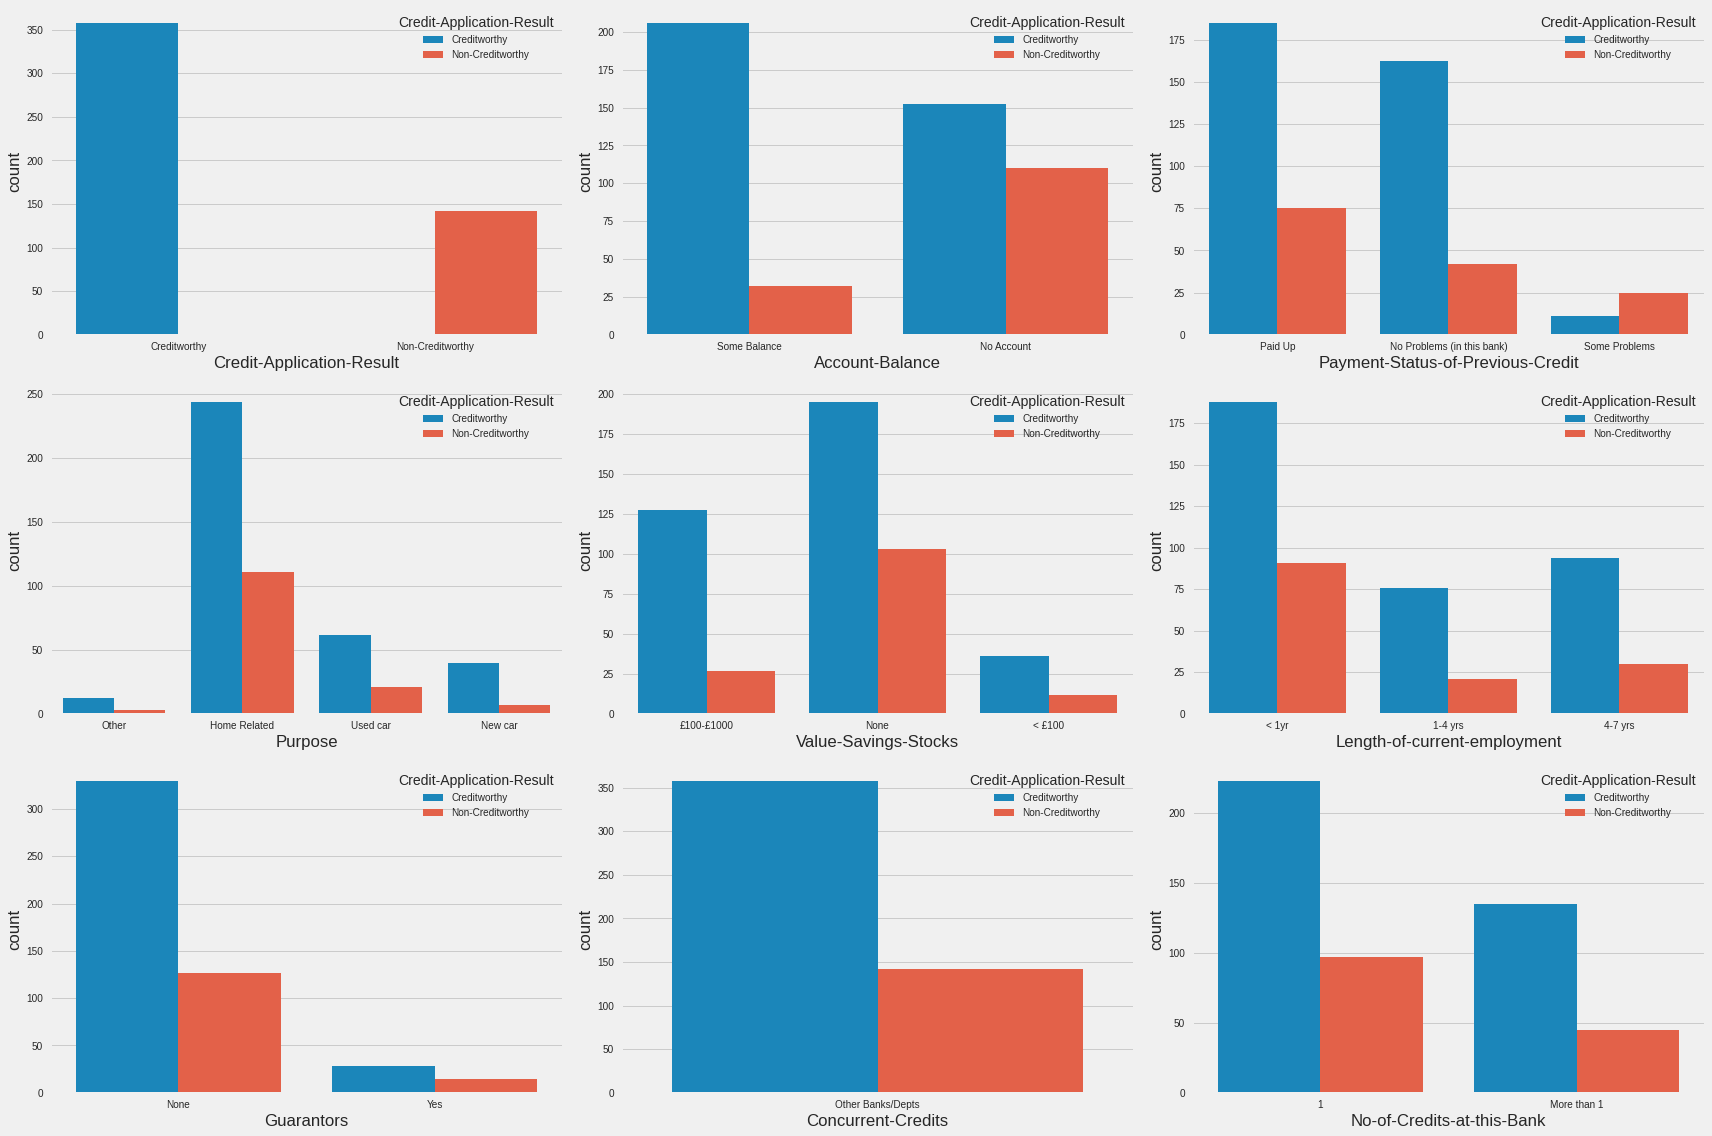

In [116]:
import matplotlib.style as style
style.use('fivethirtyeight')
fig,axes = plt.subplots(3,3, figsize=(24,16))
for index,cat_col in enumerate(cat_var):
    row,col = index//3,index%3
    sns.countplot(x=cat_col,data=train_data,hue='Credit-Application-Result',ax=axes[row,col])
    
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.show()

The plot above conveys the following about the dataset:

- Loan Approval Status: About 2/3rd of applicants have been granted loan.
- Guarantors feature shows low variability where more than 80% of the data skewed towards one data category.
- Concurrent-Credits  has one unique value.
- Applicant with credit positive history were more likely approved.
- Applicants with home related purpose were approved more.

Checking relationship between categorical variables


Set p_value = 0.05

In [117]:
# checking relationships between target variable and other categorical variables using chi-squared test
def check_relationship(df,x,y):
  table = pd.crosstab(df[x],df[y])
  test = stat()
  test.chisq(df=table)

  print('null hypothesis: {} and {} are not related'.format(x,y))
  print('altenative hypothesis: {} and {} are related'.format(x,y))
  print()
  print('test results')
  print('='*60)
  print('observed frequency values \n')
  print(table)

  print('='*60)
  print(test.expected_df)
  print('='*60)
  print(test.summary)

Target variable and Account balance

In [118]:
check_relationship(train_data,'Credit-Application-Result','Account-Balance')

null hypothesis: Credit-Application-Result and Account-Balance are not related
altenative hypothesis: Credit-Application-Result and Account-Balance are related

test results
observed frequency values 

Account-Balance            No Account  Some Balance
Credit-Application-Result                          
Creditworthy                      152           206
Non-Creditworthy                  110            32

Expected frequency counts

      No Account    Some Balance
--  ------------  --------------
 0       187.592         170.408
 1        74.408          67.592


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            1       48.5598  3.20374e-12
Log-likelihood     1       50.8098  1.01762e-12



From the results, p_value < 0.05 thus the null hypothesis is rejected. There is an association between target variable and Account balance

Target variable and Guarantors 

In [119]:
check_relationship(train_data, 'Credit-Application-Result','Guarantors',)

null hypothesis: Credit-Application-Result and Guarantors are not related
altenative hypothesis: Credit-Application-Result and Guarantors are related

test results
observed frequency values 

Guarantors                 None  Yes
Credit-Application-Result           
Creditworthy                330   28
Non-Creditworthy            127   15

Expected frequency counts

       None     Yes
--  -------  ------
 0  327.212  30.788
 1  129.788  12.212


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            1      0.655037   0.418317
Log-likelihood     1      0.635101   0.425491



From the results, p_value > 0.05 thus the null hypothesis cannot be rejected. There is no association between guarantors and target variable.

Target variable and  Purpose

In [120]:
check_relationship(train_data, 'Credit-Application-Result', 'Purpose')

null hypothesis: Credit-Application-Result and Purpose are not related
altenative hypothesis: Credit-Application-Result and Purpose are related

test results
observed frequency values 

Purpose                    Home Related  New car  Other  Used car
Credit-Application-Result                                        
Creditworthy                        244       40     12        62
Non-Creditworthy                    111        7      3        21

Expected frequency counts

      Home Related    New car    Other    Used car
--  --------------  ---------  -------  ----------
 0          254.18     33.652    10.74      59.428
 1          100.82     13.348     4.26      23.572


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            3       6.56448  0.0871538
Log-likelihood     3       7.15598  0.0670889



From the results, p_value > 0.05 thus the null hypothesis cannot be rejected. There is no association between target variable and Purpose.

Target variable and Value-Savings-Stocks

In [121]:
check_relationship(train_data, 'Credit-Application-Result', 'Value-Savings-Stocks')

null hypothesis: Credit-Application-Result and Value-Savings-Stocks are not related
altenative hypothesis: Credit-Application-Result and Value-Savings-Stocks are related

test results
observed frequency values 

Value-Savings-Stocks       < £100  None  £100-£1000
Credit-Application-Result                          
Creditworthy                   36   195         127
Non-Creditworthy               12   103          27

Expected frequency counts

      < £100     None    £100-£1000
--  --------  -------  ------------
 0    34.368  213.368       110.264
 1    13.632   84.632        43.736


Chi-squared test for independence

Test              Df    Chi-square      P-value
--------------  ----  ------------  -----------
Pearson            2        14.785  0.00061586
Log-likelihood     2        15.481  0.000434851



From the results, p_value < 0.05 thus the null hypothesis is  rejected. There is an association between target variable and Value-savings-stocks

Target variable and Length-of-Current-Employment

In [122]:
check_relationship(train_data, 'Account-Balance', 'Length-of-current-employment')

null hypothesis: Account-Balance and Length-of-current-employment are not related
altenative hypothesis: Account-Balance and Length-of-current-employment are related

test results
observed frequency values 

Length-of-current-employment  1-4 yrs  4-7 yrs  < 1yr
Account-Balance                                      
No Account                         56       54    152
Some Balance                       41       70    127

Expected frequency counts

      1-4 yrs    4-7 yrs    < 1yr
--  ---------  ---------  -------
 0     50.828     64.976  146.196
 1     46.172     59.024  132.804


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            2       5.48488  0.0644128
Log-likelihood     2       5.48991  0.0642511



From the results, p_value > 0.05 thus the null hypothesis cannot be rejected. There is no association between target variable and length of current employment

Target variable and Concurrent credits

In [123]:
check_relationship(train_data, 'Credit-Application-Result', 'Concurrent-Credits')

null hypothesis: Credit-Application-Result and Concurrent-Credits are not related
altenative hypothesis: Credit-Application-Result and Concurrent-Credits are related

test results
observed frequency values 

Concurrent-Credits         Other Banks/Depts
Credit-Application-Result                   
Creditworthy                             358
Non-Creditworthy                         142

Expected frequency counts

      Other Banks/Depts
--  -------------------
 0                  358
 1                  142


Chi-squared test for independence

Test              Df    Chi-square    P-value
--------------  ----  ------------  ---------
Pearson            0             0          1
Log-likelihood     0             0          1



p_value > 0.05, the null hypothesis cannot be rejected

From the analysis above, there’s definitely an issue of multicolinearity but features not associated with the target variables cannot be dropped because they might be dependent on other variables. 

#### Exploring numerical variables


Function that plots a histogram and boxplot

In [124]:
def plotting_chart(df, feature): 
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );

Credit amount distribution 

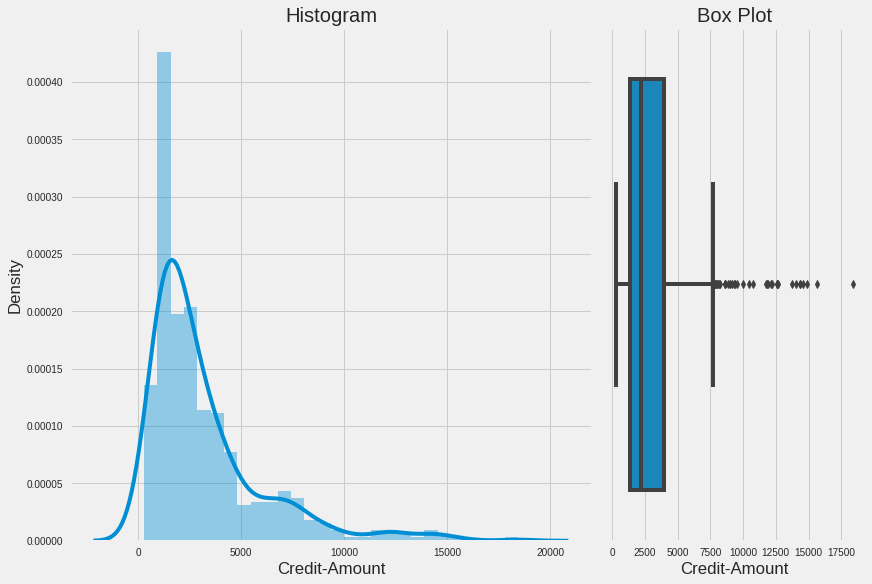

In [125]:
plotting_chart(train_data, 'Credit-Amount')

- Credit amount does not follow a normal distribution 
- Data is skewed to the right
- There are some outliers

Duration of credit month

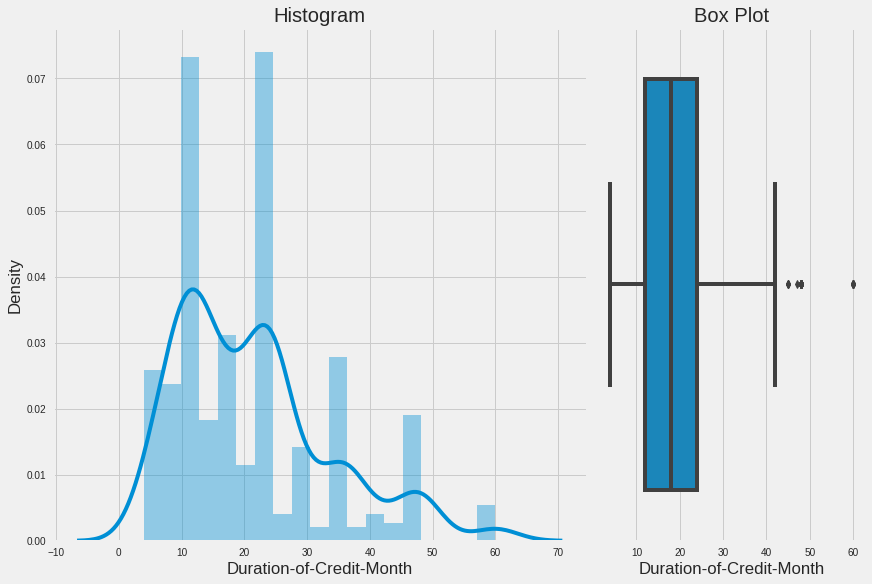

In [126]:
plotting_chart(train_data,'Duration-of-Credit-Month')

- Duration-of-Credit-Month does not exactly follow a normal distribution 
- There are a couple of outliers
- More people seem to pay back their loan within 10 and 20 months

Installment-per-cent


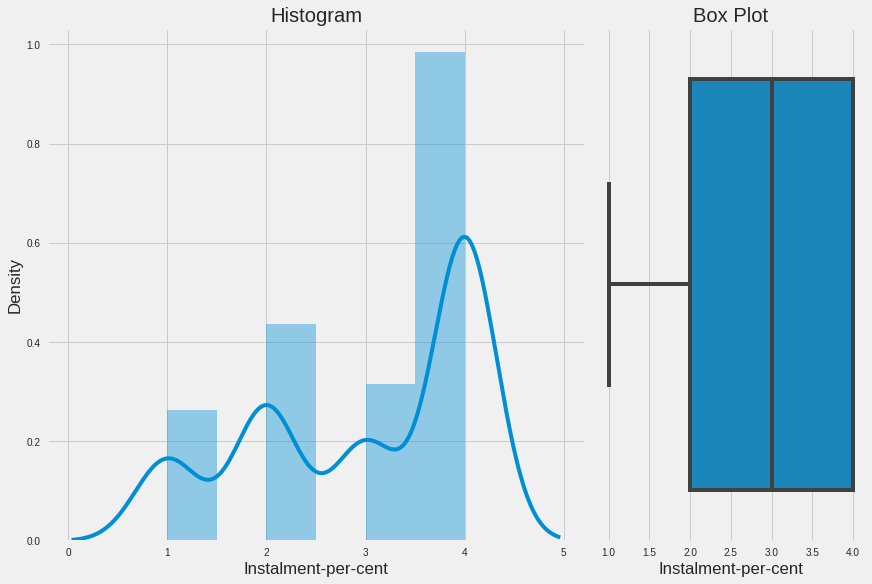

In [127]:
plotting_chart(train_data, 'Instalment-per-cent')

- Instalment-per-cent is not exactly normal
- There seem to be no outlie
- More people seem to pay their loan in four installments.

Duration-in-Current-address

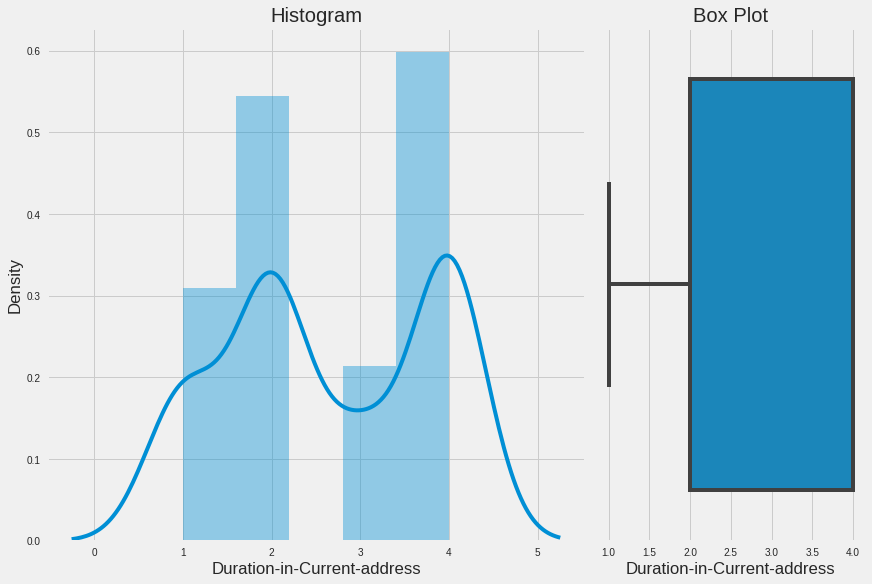

In [128]:
plotting_chart(train_data, 'Duration-in-Current-address')

- This feature cannot exactly be said to follow a normal distribution since it’s missing lots of records

Most-valuable-available-asset	

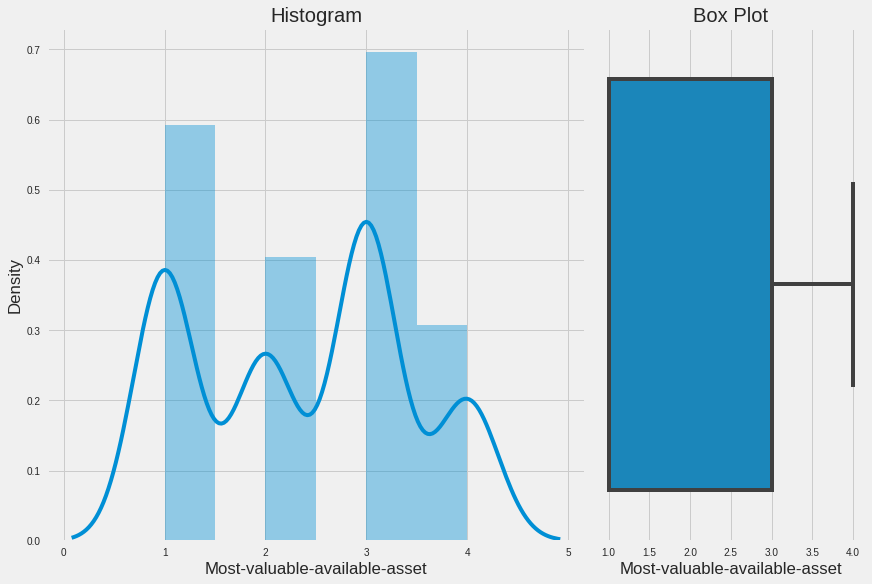

In [129]:
plotting_chart(train_data, 'Most-valuable-available-asset')

- Most-valuable-available-asset	feature seems to follow a normal distribution 
- No outliers were detected


Age-years

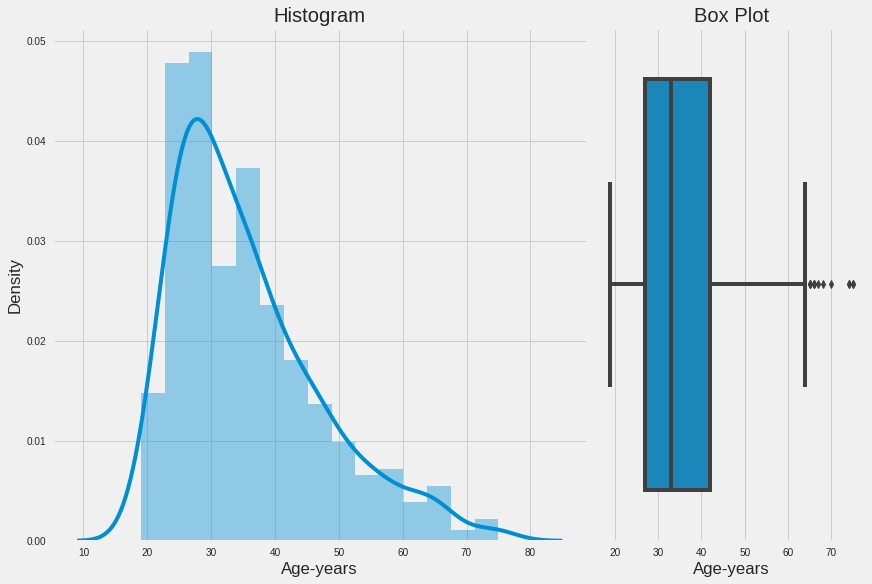

In [130]:
plotting_chart(train_data, 'Age-years')

- This feature seems to follow a normal distribution 
- Majority of loan applicants are between 25 and 40
- There seem to be some outliers 

Type-of-apartment

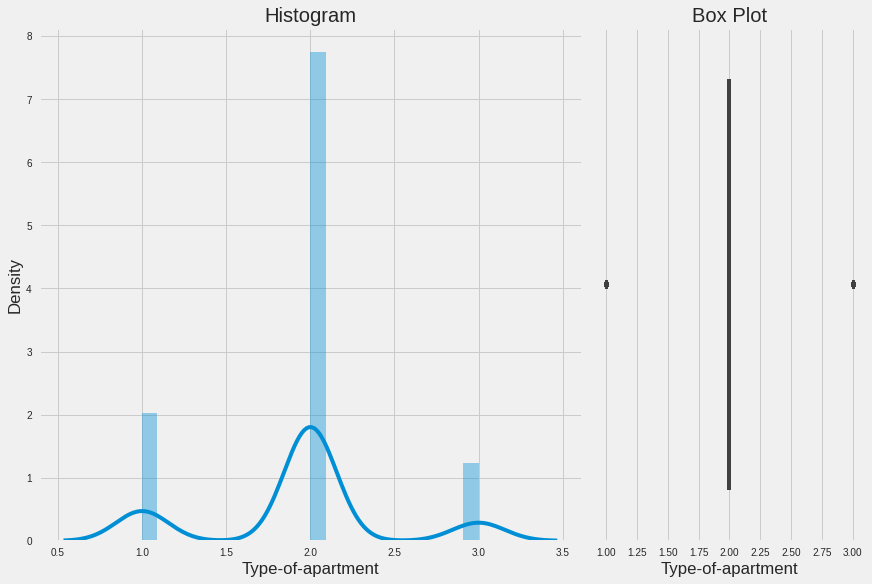

In [131]:
plotting_chart(train_data, 'Type-of-apartment')

- More applicants belong to apartment 2 type.
- This distribution shows low variability hence, feature would be dropped


Occupation

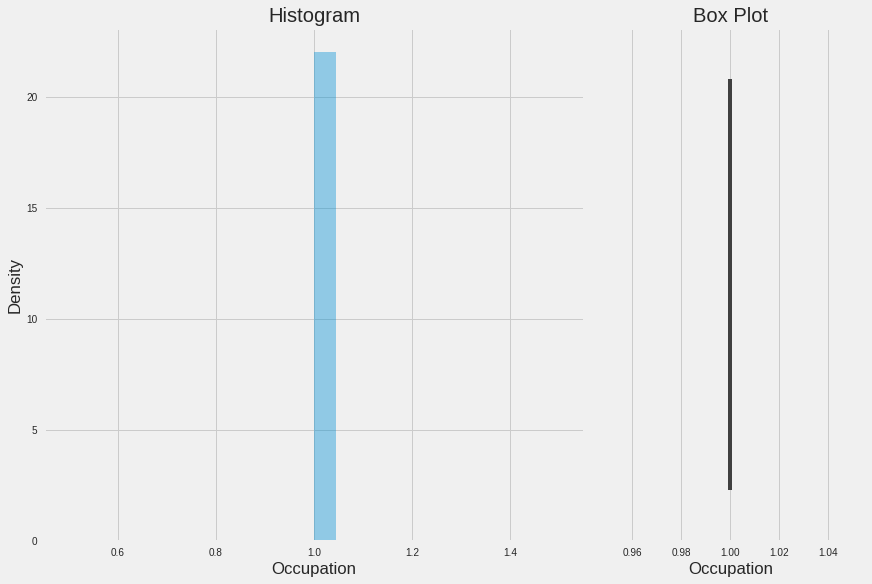

In [132]:
plotting_chart(train_data, 'Occupation')

- Every applicant had one occupation 
- This distribution shows low variability hence, feature would be dropped 


No-of-dependents

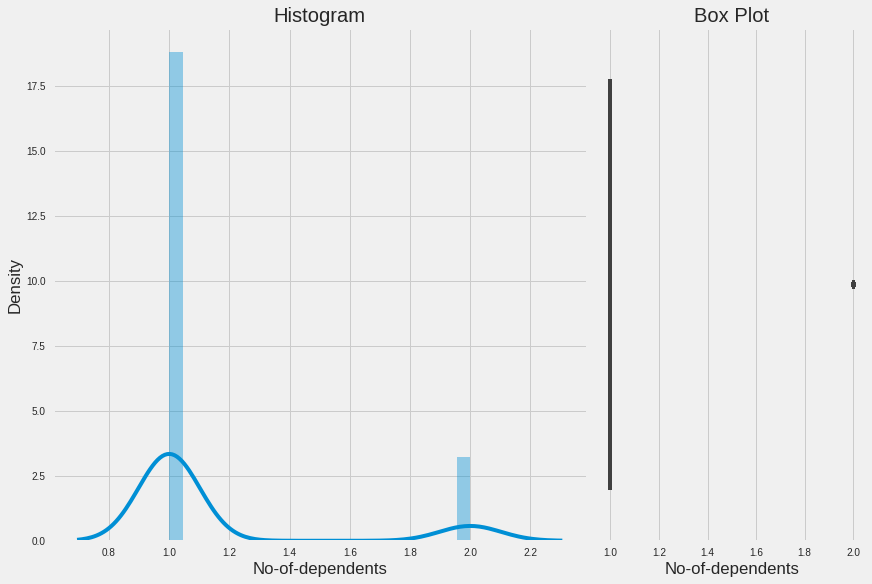

In [133]:
plotting_chart(train_data, 'No-of-dependents')

- Most of the applicants had one dependent
- This feature would be dropped 

Foreign-Worker

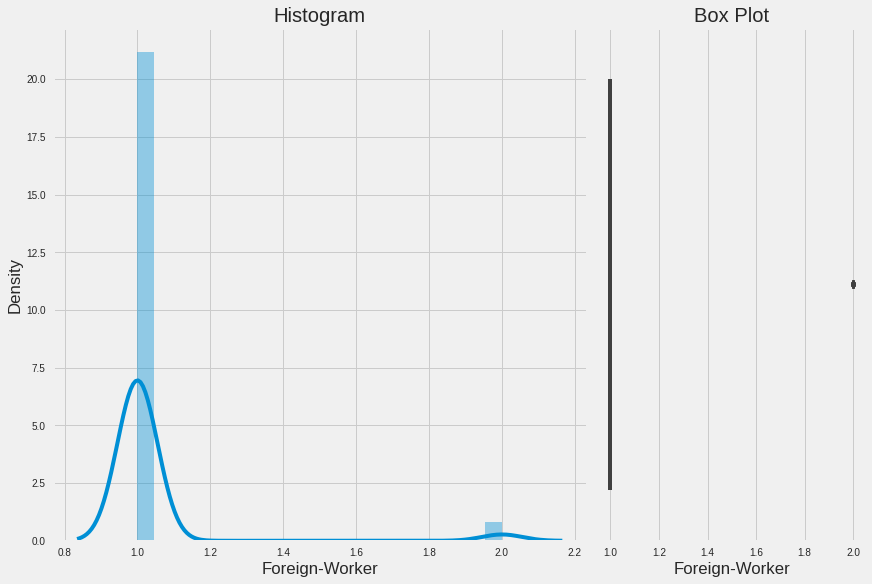

In [134]:
plotting_chart(train_data, 'Foreign-Worker')

- This feature would be dropped since majority of the records belong to one outcome. ie low variability
- This feature would be dropped

Correlation between numerical variables


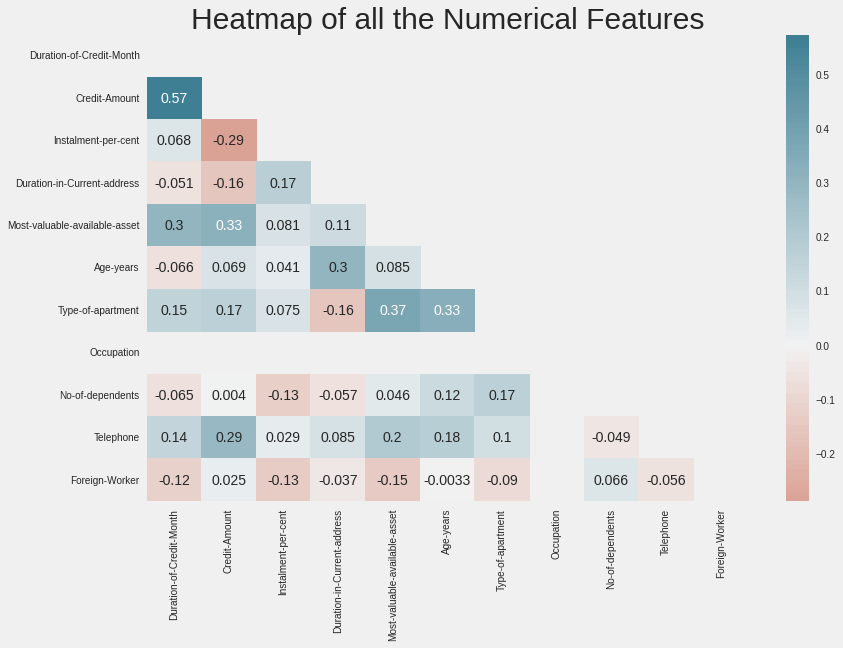

In [135]:
## Plot fig size. 
style.use('fivethirtyeight')
#sns.set_style('whitegrid')
plt.subplots(figsize = (12,8))

# Generate a mask for the upper triangle.
mask = np.zeros_like(train_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train_data.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );
## title. 
plt.title("Heatmap of all the Numerical Features", fontsize = 30);

There appears to be no significant correlation amongst the variables.

## Feature Engineering

Making sure the purpose feature is the same for both train and test

In [136]:
train_data['Purpose'].replace({'Used car':'Other','New car':'Other'},inplace=True)

In [137]:
test_data['Purpose'].replace({'Used car':'Other','New car':'Other'},inplace=True)

## Data Preprocessing  

#### Data Quality Assessment 
Mismatched data types
- Telephone should not have an int data type. (this feature would be dropped since theres no understanding what data type it belongs to)
- Type of apartments is categorical so, it should have been an object 

Data outliers
- Age-years, duration-of-credit-month, credit-amount contained outliers

Missing data
- Concurrent-Credits, Age-years had missing records

#### Data Cleaning
Dropping irrelevant columns

In [138]:
df = train_data.drop(columns=['Occupation', 'Telephone','Concurrent-Credits',\
                        'Duration-in-Current-address','Guarantors',\
                       'No-of-dependents','Foreign-Worker','Type-of-apartment'], axis=1)

In [139]:
df1 = test_data.drop(columns=['Occupation', 'Telephone','Concurrent-Credits',\
                        'Duration-in-Current-address','Guarantors',\
                       'No-of-dependents','Foreign-Worker','Type-of-apartment'], axis=1)

Handling missing values

In [140]:
# filling missing values with the median class
median_age = round(df['Age-years'].median())
df['Age-years']= df['Age-years'].fillna(median_age)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Credit-Application-Result          500 non-null    object 
 1   Account-Balance                    500 non-null    object 
 2   Duration-of-Credit-Month           500 non-null    int64  
 3   Payment-Status-of-Previous-Credit  500 non-null    object 
 4   Purpose                            500 non-null    object 
 5   Credit-Amount                      500 non-null    int64  
 6   Value-Savings-Stocks               500 non-null    object 
 7   Length-of-current-employment       500 non-null    object 
 8   Instalment-per-cent                500 non-null    int64  
 9   Most-valuable-available-asset      500 non-null    int64  
 10  Age-years                          500 non-null    float64
 11  No-of-Credits-at-this-Bank         500 non-null    object 

#### Handling categorical features 

Train data

In [141]:
# Dropping the target column from the dataset first
df = df.drop(['Credit-Application-Result'], axis=1)

# Empting list to store columns with categorical data
categorical = []
for col, value in df.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Storing the numerical columns in a list numerical
num_variables = df.columns.difference(categorical)

In [142]:
# Storing the categorical data in a dataframe
df_cat = df[categorical]
# creating dummy values
df_cat = pd.get_dummies(df_cat,drop_first=True)
df_cat.head()

,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1
0,1,1,0,1,0,1,0,1,0
1,1,1,0,0,0,1,0,1,0
2,1,0,0,0,1,0,0,0,1
3,1,0,0,0,1,0,0,0,0
4,0,1,0,0,1,0,0,1,0


In [143]:
# Storing the numerical features to a dataframe.
df_num = df[num_variables]
# combining the two dataframes
X = pd.concat([df_num, df_cat], axis=1)

In [144]:
X.head()

,Age-years,Credit-Amount,Duration-of-Credit-Month,Instalment-per-cent,Most-valuable-available-asset,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1
0,33.0,1494,4,1,1,1,1,0,1,0,1,0,1,0
1,29.0,1494,4,1,1,1,1,0,0,0,1,0,1,0
2,42.0,1544,4,2,1,1,0,0,0,1,0,0,0,1
3,37.0,3380,4,1,1,1,0,0,0,1,0,0,0,0
4,27.0,343,6,4,1,0,1,0,0,1,0,0,1,0


In [145]:
# Defining a dictionary for the target class
target_class = {'Creditworthy':1, 'Non-Creditworthy':0}
# Using the pandas apply method to numerically encode target variable
y = train_data['Credit-Application-Result'].apply(lambda x: target_class[x])
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Credit-Application-Result, dtype: int64

Test data

In [146]:
# Empting list to store columns with categorical data
cate = []
for col, value in df1.iteritems():
    if value.dtype == 'object':
        cate.append(col)

# Storing the numerical columns in a list numerical
num_vars = df1.columns.difference(cate)

In [147]:
# Storing the categorical data in a dataframe
df1_cat = df1[cate]
# creating dummy values
df1_cat = pd.get_dummies(df1_cat,drop_first=True)
df1_cat.head()

,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1
0,0,0,0,0,1,0,0,1,1
1,0,0,0,0,1,0,0,1,1
2,0,1,0,0,0,1,0,1,0
3,0,0,0,0,1,0,0,1,1
4,0,0,0,0,1,0,0,0,0


In [148]:
# Storing the numerical features to a dataframe.
df1_num = df1[num_vars]
# combining the two dataframes
XT = pd.concat([df1_num, df1_cat], axis=1)

In [149]:
XT.head()

,Age-years,Credit-Amount,Duration-of-Credit-Month,Instalment-per-cent,Most-valuable-available-asset,Account-Balance_Some Balance,Payment-Status-of-Previous-Credit_Paid Up,Payment-Status-of-Previous-Credit_Some Problems,Purpose_Other,Value-Savings-Stocks_None,Value-Savings-Stocks_£100-£1000,Length-of-current-employment_4-7 yrs,Length-of-current-employment_< 1yr,No-of-Credits-at-this-Bank_More than 1
0,36,2799,9,2,1,0,0,0,0,1,0,0,1,1
1,39,2122,12,3,1,0,0,0,0,1,0,0,1,1
2,23,3758,24,1,4,0,1,0,0,0,1,0,1,0
3,36,3905,11,2,1,0,0,0,0,1,0,0,1,1
4,31,1957,6,1,3,0,0,0,0,1,0,0,0,0


#### Splitting data into train and test set

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.30, stratify=y,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(350, 14) (350,)
(150, 14) (150,)


#### Scaling the data

Train data

In [151]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

Test data




In [152]:
XT = scale.transform(XT)

## Model training

Function that evaluates the model

In [153]:
model = list()
precision = list()
recall = list()
f1score = list()
roc_auc = list()
model_type = list()
# function that trains the model and computes the classification metrics
def test_eval(clf_model, X_test, y_test, algo=None,model_types=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('ROC_AUC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    f1score.append(f1_score(y_test,y_pred))
    roc_auc.append(roc_auc_score(y_test, y_prob[:,1]))
    model_type.append(model_types)

#### Model-1: Logistic Regression


Base model

In [154]:
# instantiate logreg
logreg = LogisticRegression(random_state=42)

lr = LogisticRegression().fit(X_train, y_train)

In [163]:
print('Train score :',lr.score(X_train,y_train))

Train score : 0.8114285714285714


In [155]:
# model evaluation
test_eval(lr, X_test, y_test, 'Logistic Regression','Base')

Confusion Matrix
[[19 24]
 [10 97]] 

Classification Report
              precision    recall  f1-score   support

           0       0.66      0.44      0.53        43
           1       0.80      0.91      0.85       107

    accuracy                           0.77       150
   macro avg       0.73      0.67      0.69       150
weighted avg       0.76      0.77      0.76       150
 

ROC_AUC
0.7515757444033905


Base model is overfitting

Tuned Model

In [156]:
# instantiate logreg
logreg = LogisticRegression(random_state=42)

#define grid
param_grid_lr=[{'solver':['saga'],'C':[0.1,1,10,100],'penalty':['elasticnet','l1','l2']},
               {'solver':['lbfgs'],'C':[0.1,1,10,100],'penalty':['l2']}, {'solver':['newton-cg'],'C':[0.1,1,10],'penalty':['l2','l1']}]

# validation parameters               
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# model training
gs_lr =GridSearchCV(logreg,param_grid_lr,cv=cv)
gs_lr.fit(X_train,y_train)
test_score = gs_lr.score(X_test,y_test)
print("test score:",test_score)
print("best parameters: ",gs_lr.best_params_)
print("best train score: ", gs_lr.best_score_)

test score: 0.7666666666666667
best parameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
best train score:  0.782857142857143


Model evaluation

In [157]:
test_eval(gs_lr, X_test, y_test, 'Logistic Regression','Tuned')


Confusion Matrix
[[17 26]
 [ 9 98]] 

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.40      0.49        43
           1       0.79      0.92      0.85       107

    accuracy                           0.77       150
   macro avg       0.72      0.66      0.67       150
weighted avg       0.75      0.77      0.75       150
 

ROC_AUC
0.7587480982395131


#### Model-2: Decision Tree

Base Model

In [158]:
# instantiate and train model
tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [164]:
print('Train score :',tree.score(X_train,y_train))

Train score : 1.0


In [159]:
# model evaluation
test_eval(tree, X_test, y_test, 'Decision Tree','Base')


Confusion Matrix
[[24 19]
 [34 73]] 

Classification Report
              precision    recall  f1-score   support

           0       0.41      0.56      0.48        43
           1       0.79      0.68      0.73       107

    accuracy                           0.65       150
   macro avg       0.60      0.62      0.60       150
weighted avg       0.68      0.65      0.66       150
 

ROC_AUC
0.6201912627689633


Tuned Model

In [160]:
# instantiating model
dtr = DecisionTreeClassifier(random_state=42)

estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

# parameters
params = { 
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf}

# model validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# train model
gs_dtr = GridSearchCV(dtr, params, cv=5, n_jobs=-1, verbose=2)
gs_dtr.fit(X_train, y_train)
gs_dtr.best_estimator_

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=20,
                       random_state=42, splitter='random')

In [161]:
print("best train score: ", gs_dtr.best_score_)

best train score:  0.76


In [162]:
# model evaluation
test_eval(gs_dtr, X_test, y_test, 'Decision Tree','Tuned')

Confusion Matrix
[[22 21]
 [18 89]] 

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.51      0.53        43
           1       0.81      0.83      0.82       107

    accuracy                           0.74       150
   macro avg       0.68      0.67      0.68       150
weighted avg       0.73      0.74      0.74       150
 

ROC_AUC
0.7162573353618779


Visulazing Decision Tree with Max Depth = 5

In [ ]:
import graphviz 
from sklearn.tree import export_graphviz
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re


In [ ]:
with open("tree1.dot", 'w') as f:
     f = export_graphviz(gs_dtr.best_estimator_,
                              out_file=f,
                              max_depth = 5,
                              impurity = False,
                              feature_names = X.columns.tolist(),
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )

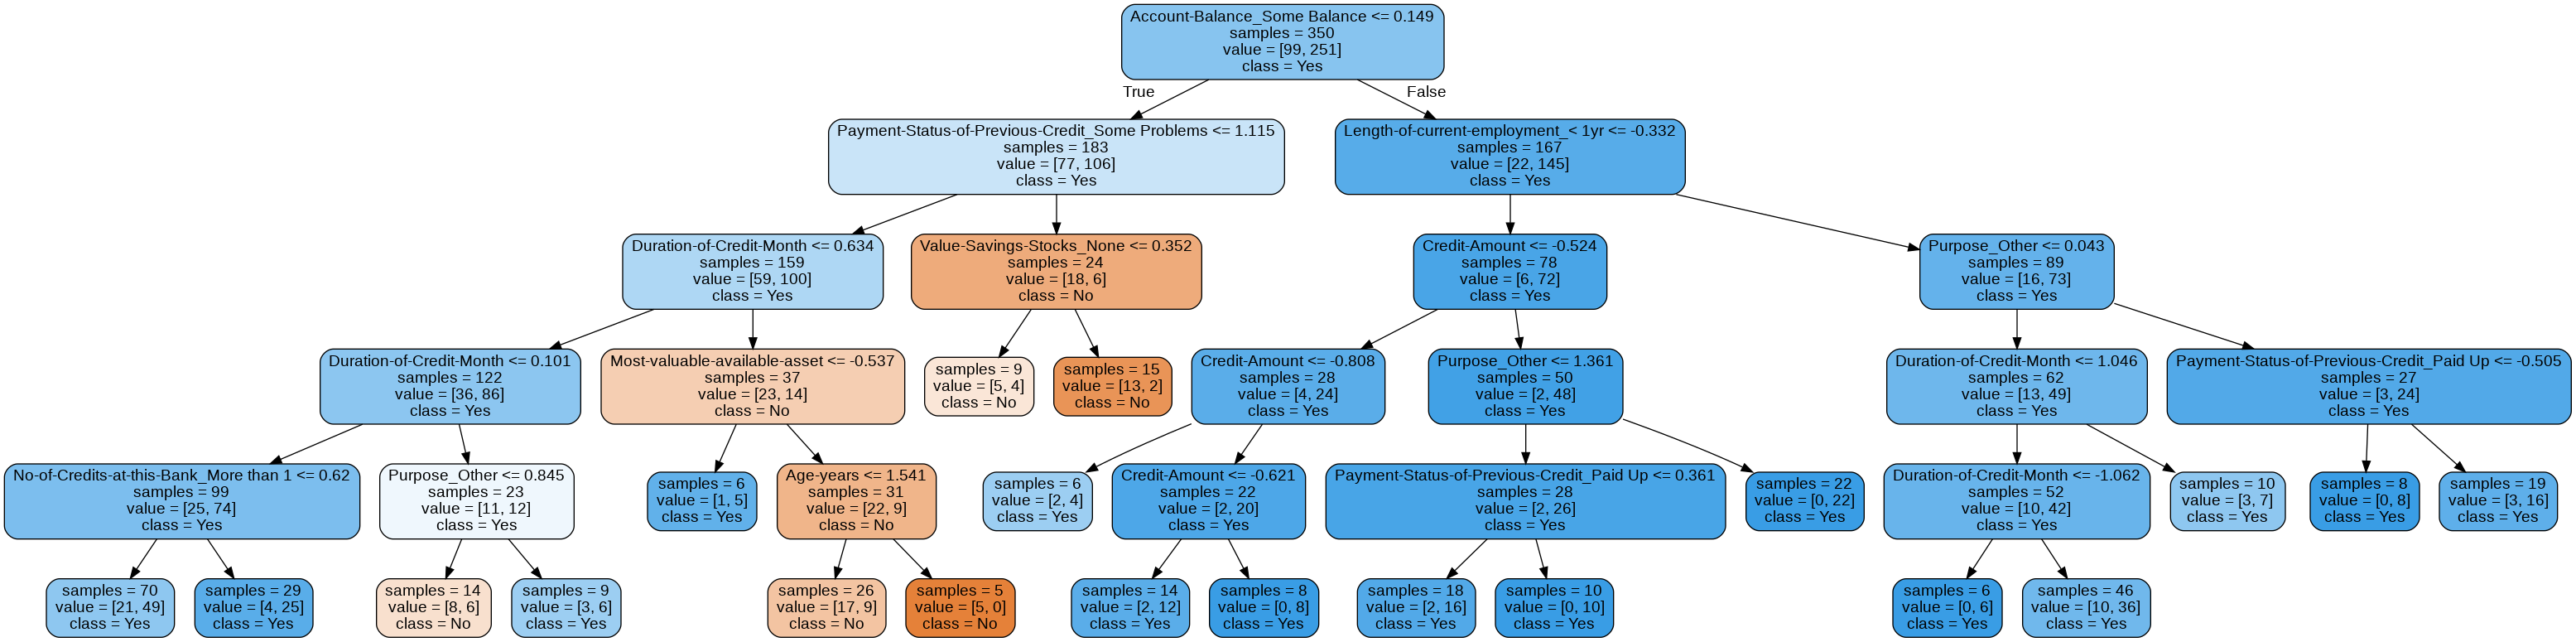

In [ ]:
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png")

#### Model-3: Random Forest

Base model

In [165]:
# instantiate model
rf_classifier=RandomForestClassifier(random_state=42).fit(X_train,y_train)
print('Train score :',rf_classifier.score(X_train,y_train))

Train score : 1.0


In [166]:
# model evaluation
test_eval(rf_classifier, X_test, y_test, 'Random Forest','Base')

Confusion Matrix
[[19 24]
 [ 8 99]] 

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.44      0.54        43
           1       0.80      0.93      0.86       107

    accuracy                           0.79       150
   macro avg       0.75      0.68      0.70       150
weighted avg       0.78      0.79      0.77       150
 

ROC_AUC
0.7263638339491415


Tuned Model

In [167]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [168]:
rf=RandomForestClassifier(random_state=42,)
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=5,verbose=2,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=2)

In [169]:
# instantiating random forest
rfc = RandomForestClassifier(random_state=42)

# defining parameters
rf_params = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+2, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, rf_randomcv.best_params_['n_estimators'] - 100, 
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 100, rf_randomcv.best_params_['n_estimators'] + 200]
}

# model validation
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# train model with gridsearch
gs_rfc = GridSearchCV(rfc, rf_params, cv=5, n_jobs=-1, verbose=2,return_train_score=True)
gs_rfc.fit(X_train, y_train)
best_rfc = gs_rfc.best_estimator_
gs_rfc.best_estimator_

Fitting 5 folds for each of 75 candidates, totalling 375 fits


RandomForestClassifier(criterion='entropy', max_depth=670, max_features='log2',
                       min_samples_split=10, n_estimators=800, random_state=42)

In [170]:
# best train score
print("best train score: ", gs_rfc.best_score_)

best train score:  0.7914285714285715


In [171]:
# model evaluation 
test_eval(gs_rfc, X_test, y_test, 'Random Forest','Tuned')


Confusion Matrix
[[16 27]
 [ 8 99]] 

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.37      0.48        43
           1       0.79      0.93      0.85       107

    accuracy                           0.77       150
   macro avg       0.73      0.65      0.66       150
weighted avg       0.75      0.77      0.74       150
 

ROC_AUC
0.7200608563355791


model is biased towards the creditworthy class

#### Model-4: XGBoost

Base Model

In [172]:
xgb_booster = xgb.XGBClassifier(random_state=42).fit(X_train,y_train)

In [ ]:
# model evaluation
test_eval(xgb_booster, X_test, y_test, 'XGBoost','Base')

In [173]:
# defining parameters
xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.001, 0.01, 0.1, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators':[10,20,30,40,50,60]
        }
# instantiate xgboost
booster = xgb.XGBClassifier()

# model training and  validation

# grid
gs_xgb = GridSearchCV(booster, xgb_params, n_jobs=-1,cv=5,verbose=2)
gs_xgb.fit(X_train, y_train)
gs_xgb.best_estimator_

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits


XGBClassifier(colsample_bytree=0.6, gamma=0.001, n_estimators=60, subsample=0.6)

In [174]:
# best train score
print("best train score: ", gs_xgb.best_score_)

best train score:  0.7942857142857143


In [175]:
# model evaluation 
test_eval(gs_xgb, X_test, y_test, 'XGBoost','Tuned')


Confusion Matrix
[[19 24]
 [15 92]] 

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.44      0.49        43
           1       0.79      0.86      0.83       107

    accuracy                           0.74       150
   macro avg       0.68      0.65      0.66       150
weighted avg       0.73      0.74      0.73       150
 

ROC_AUC
0.7189741360573788


#### Model-5: SDGClassifier

Base model

In [178]:
sdg_classifier = SGDClassifier(random_state=42,loss='modified_huber').fit(X_train,y_train)

In [179]:
# model evaluation
test_eval(sdg_classifier,X_test,y_test, 'SDG','Base')

Confusion Matrix
[[18 25]
 [24 83]] 

Classification Report
              precision    recall  f1-score   support

           0       0.43      0.42      0.42        43
           1       0.77      0.78      0.77       107

    accuracy                           0.67       150
   macro avg       0.60      0.60      0.60       150
weighted avg       0.67      0.67      0.67       150
 

ROC_AUC
0.5919365355357531


Tuned Model

In [180]:
# instantiating gradient boost
sdg = SGDClassifier(random_state=42,shuffle=True,max_iter=1000)

In [71]:
sdg.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [181]:

# parameters
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"]}

# model validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
gs_sdg = GridSearchCV(sdg, param_grid=params,n_jobs=-1,verbose=2,cv=cv)

# model training
gs_sdg.fit(X_train, y_train)
best_grid=gs_sdg.best_estimator_
# predict
scores = gs_sdg.score(X_test,y_test)
print("test score:",scores)
print("best parameters: ",gs_sdg.best_params_)
print("best train score: ", gs_sdg.best_score_)

Fitting 30 folds for each of 48 candidates, totalling 1440 fits
test score: 0.7733333333333333
best parameters:  {'alpha': 0.1, 'loss': 'modified_huber', 'penalty': 'l2'}
best train score:  0.7847619047619049


In [182]:
test_eval(gs_sdg,X_test,y_test, 'SDG','Tuned')

Confusion Matrix
[[18 25]
 [ 9 98]] 

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.42      0.51        43
           1       0.80      0.92      0.85       107

    accuracy                           0.77       150
   macro avg       0.73      0.67      0.68       150
weighted avg       0.76      0.77      0.76       150
 

ROC_AUC
0.7572266898500326


## Model Comparision

#### comparing metrics of the five models

In [183]:
model_eval = pd.DataFrame({'model':model,
                           'model_type':model_type,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':f1score,
                            'AUC-ROC':roc_auc})

In [189]:
model_eval.sort_values(by='AUC-ROC',ascending=False,ignore_index=True)

,model,model_type,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,Tuned,0.790323,0.915888,0.848485,0.758748
1,SDG,Tuned,0.796748,0.915888,0.852174,0.757227
2,Logistic Regression,Base,0.801653,0.906542,0.850877,0.751576
3,Random Forest,Base,0.804878,0.925234,0.860870,0.726364
4,Random Forest,Tuned,0.785714,0.925234,0.849785,0.720061
5,XGBoost,Tuned,0.793103,0.859813,0.825112,0.718974
6,Decision Tree,Tuned,0.809091,0.831776,0.820276,0.716257
7,Decision Tree,Base,0.793478,0.682243,0.733668,0.620191
8,SDG,Base,0.768519,0.775701,0.772093,0.591937


Based on the f1-score, Random forest would be retrained as the final model

ROC_AUC curves

In [190]:
# predict probabilities
pred_prob_lr = gs_lr.predict_proba(X_test)
pred_prob_dtr = gs_dtr.predict_proba(X_test)
pred_prob_rf = gs_rfc.predict_proba(X_test)
pred_prob_xgb = gs_xgb.predict_proba(X_test)
pred_prob_sdg = gs_sdg.predict_proba(X_test)

from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob_lr[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob_dtr[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob_rf[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob_xgb[:,1], pos_label=1)
fpr5, tpr5, thresh5 = roc_curve(y_test, pred_prob_sdg[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


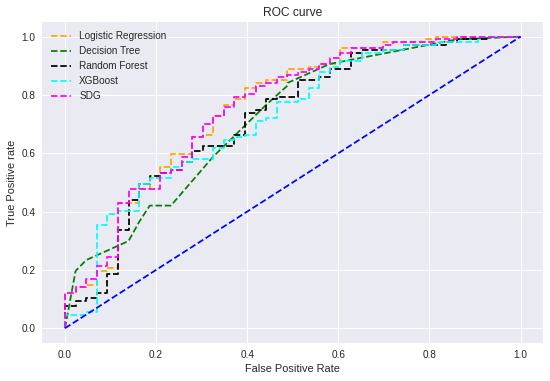

In [191]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Decision Tree')
plt.plot(fpr3, tpr3, linestyle='--',color='black', label='Random Forest')
plt.plot(fpr4, tpr4, linestyle='--',color='cyan', label='XGBoost')
plt.plot(fpr5, tpr5, linestyle='--',color='magenta', label='SDG')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#### Observations
- SDG actual classifier gave the best results based on f1-score and ROC_AUC score
-
The final model would be trained using the best parameters from the gridsearch

## Final Model Training 
### SDG Classifier

 re-training the SDG model with the best optimal values and then check its performance:

In [192]:
from sklearn.metrics import accuracy_score
y_pred=best_grid.predict(X_test)
y_prob=best_grid.predict_proba(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(best_grid.score(X_train,y_train)))
print(classification_report(y_test,y_pred))
print("ROC_AUC {}".format(roc_auc_score(y_test, y_prob[:,1])))

[[18 25]
 [ 9 98]]
Accuracy Score 0.8
              precision    recall  f1-score   support

           0       0.67      0.42      0.51        43
           1       0.80      0.92      0.85       107

    accuracy                           0.77       150
   macro avg       0.73      0.67      0.68       150
weighted avg       0.76      0.77      0.76       150

ROC_AUC 0.7572266898500326


## Introducing and testing model with external data

Loan eligibility predictions 

In [193]:
Predicted_y = best_grid.predict(XT)

In [194]:
pred = pd.DataFrame(Predicted_y)

In [195]:
pred.value_counts()

1    415
0     85
dtype: int64

After Introducing the external data to the model to check the number of people eligible for a loan, the following was observed:
- 415 people are eligible for loan out of the 500 applicants.
- 85 people should not be  considered.